In [1]:
# This notebook contasins the code to differentiate images based on sports

In [2]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [3]:
from os import listdir
import wget

## Loading the data

In [4]:
PATH = "/home/ubuntu/datasets/sports_images/"
sz=224

In [6]:
files = listdir(f'{PATH}train/baseball')[:5]
files

['bs5.jpg', 'bs21.jpg', 'bs25.jpg', 'bs10.jpg', 'bs13.jpg']

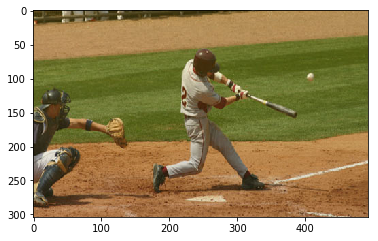

In [9]:
img = plt.imread(f'{PATH}train/baseball/{files[0]}')
plt.imshow(img);

The numbers above mean the image has 304*493 pixels with 3 channels (R, G, and B)

In [10]:
img.shape

(304, 493, 3)

Lets verify it using img.size function

In [11]:
img.size

449616

In [12]:
304*493*3

449616

Let's have a look at what type of numbers are stored by selecting first 4 rows and columns.

In [13]:
img[:4,:4]

array([[[ 84,  66,  20],
        [ 84,  66,  20],
        [ 91,  73,  27],
        [ 86,  68,  22]],

       [[ 95,  77,  31],
        [ 95,  77,  31],
        [100,  82,  36],
        [ 94,  76,  30]],

       [[ 97,  80,  36],
        [ 95,  78,  34],
        [ 99,  82,  38],
        [ 92,  75,  31]],

       [[ 81,  66,  23],
        [ 80,  65,  22],
        [ 83,  68,  25],
        [ 76,  61,  18]]], dtype=uint8)

## Building a simple model

We're going to use a pre-trained model, that is, a model created by someone else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision.

### Download pre-trained models

I used the following links to download the model

    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth'

In [10]:
url = "https://download.pytorch.org/models/resnet152-b121ed2d.pth"
wget.download(url, '/home/ubuntu/pretrained_models/')

'/home/ubuntu/pretrained_models//resnet152-b121ed2d.pth'

Lets check the size of each model

In [14]:
!ls -l --block-size=M /home/ubuntu/pretrained_models/

total 499M
-rw-rw-r-- 1 ubuntu ubuntu 171M Jan  9 19:12 resnet101-5d3b4d8f.pth
-rw-r--r-- 1 ubuntu ubuntu 231M Jan  9 19:17 resnet152-b121ed2d.pth
-rw-rw-r-- 1 ubuntu ubuntu  98M Jan  9 19:11 resnet50-19c8e357.pth


As you can see above, when the number of number of layers double the pre-trained models also double in size.

Another simple way is to just import it from torchvision

In [15]:
from torchvision.models import resnet18
from torchvision.models import resnet34

In [16]:
# We are using pre-trained model called resnet34
arch=resnet34
# and then use arch as parameter

If you wish to check all available pretrained models:

In [17]:
from torchvision import models
dir(models)

['AlexNet',
 'DenseNet',
 'Inception3',
 'ResNet',
 'SqueezeNet',
 'VGG',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'inception',
 'inception_v3',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'squeezenet',
 'squeezenet1_0',
 'squeezenet1_1',
 'vgg',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19',
 'vgg19_bn']

### Data Preprocessing

In [51]:
from torchvision import transforms
transform_for_sports_data = transforms.Compose([            
 transforms.Resize(256),                    # Resize the image to 256×256 pixels.
 transforms.CenterCrop(224),                # Crop the image to 224×224 pixels about the center.
 transforms.RandomHorizontalFlip(),          # As these are sports images lets do only horrizonal flip
 transforms.ToTensor(),                     # Convert the image to PyTorch Tensor data type.
 transforms.Normalize(                      # Normalize the image by setting its mean and standard deviation to the specified values.
 mean=[0.485, 0.456, 0.406],            
 std=[0.229, 0.224, 0.225]                  
 )])

List of all transforms here:

https://pytorch.org/docs/stable/torchvision/transforms.html

In [16]:
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

In [52]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(PATH, transform=transform_for_sports_data),
    batch_size=4,
    num_workers=0,
    shuffle=True)

In [53]:
train_loader.dataset

Dataset ImageFolder
    Number of datapoints: 60
    Root Location: /home/ubuntu/datasets/sports_images/
    Transforms (if any): Compose(
                             Resize(size=256, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(224, 224))
                             RandomHorizontalFlip(p=0.5)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None

In [54]:
dataiter = iter(train_loader)   # provided one batch at a time
images = dataiter.next()        # as per the batch size (bs) 4 images are pulled along with their labels

In [55]:
len(images)

2

In [58]:
len(images[0]),len(images[1])

(4, 4)

In [61]:
images[1]

tensor([0, 1, 1, 0])

In [73]:
im1 = images[0][0]
type(im1), im1.shape

(torch.Tensor, torch.Size([3, 224, 224]))

In [67]:
images[0][0]

tensor([[[-1.9295, -1.8782, -1.8439,  ..., -1.9295, -1.9295, -1.9295],
         [-1.9467, -1.8782, -1.8610,  ..., -1.9295, -1.9124, -1.9124],
         [-1.9295, -1.9124, -1.8953,  ..., -1.9467, -1.9295, -1.9124],
         ...,
         [-0.0801, -0.0116,  0.0741,  ...,  0.3652,  0.3138,  0.1254],
         [ 0.0056,  0.0569, -0.1143,  ...,  0.3994,  0.0569, -0.2513],
         [-0.3883, -0.4226, -0.5938,  ...,  0.0741,  0.1597,  0.2796]],

        [[-1.7906, -1.7381, -1.7031,  ..., -1.8431, -1.8431, -1.8431],
         [-1.8081, -1.7381, -1.7206,  ..., -1.8606, -1.8431, -1.8431],
         [-1.7731, -1.7556, -1.7381,  ..., -1.8782, -1.8606, -1.8431],
         ...,
         [-0.4076, -0.3200, -0.2500,  ..., -0.0574, -0.1099, -0.3025],
         [-0.3375, -0.2850, -0.4601,  ...,  0.0301, -0.3375, -0.6352],
         [-0.7752, -0.8102, -0.9853,  ..., -0.3025, -0.2150, -0.0924]],

        [[-1.4384, -1.3861, -1.3513,  ..., -1.5604, -1.5604, -1.5604],
         [-1.4559, -1.3861, -1.3687,  ..., -1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


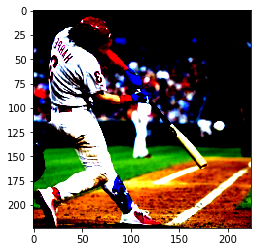

In [75]:
plt.imshow(im1.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


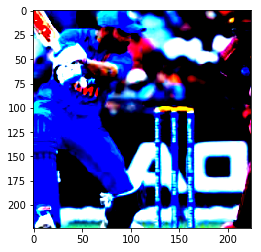

In [76]:
im1 = images[0][1]
plt.imshow(im1.permute(1, 2, 0))

## PyTorch tutorial code

In [19]:
from torchvision import datasets, models, transforms
import os

In [20]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [21]:
data_dir = '/home/ubuntu/datasets/sports_images/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

In [23]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [24]:
len(dataloaders), type(dataloaders)

(2, dict)

In [25]:
dataloaders.items()

dict_items([('train', <torch.utils.data.dataloader.DataLoader object at 0x7f4e702d3cc0>), ('val', <torch.utils.data.dataloader.DataLoader object at 0x7f4e702d3da0>)])

In [26]:
len(dataloaders['train']), len(dataloaders['val'])

(13, 3)

In [27]:
dataloaders['val'].dataset.imgs

[('/home/ubuntu/datasets/sports_images/val/baseball/bs26.jpg', 0),
 ('/home/ubuntu/datasets/sports_images/val/baseball/bs27.jpg', 0),
 ('/home/ubuntu/datasets/sports_images/val/baseball/bs28.jpg', 0),
 ('/home/ubuntu/datasets/sports_images/val/baseball/bs29.jpg', 0),
 ('/home/ubuntu/datasets/sports_images/val/baseball/bs30.jpg', 0),
 ('/home/ubuntu/datasets/sports_images/val/cricket/cr26.jpg', 1),
 ('/home/ubuntu/datasets/sports_images/val/cricket/cr27.jpg', 1),
 ('/home/ubuntu/datasets/sports_images/val/cricket/cr28.jpg', 1),
 ('/home/ubuntu/datasets/sports_images/val/cricket/cr29.jpg', 1),
 ('/home/ubuntu/datasets/sports_images/val/cricket/cr30.jpg', 1)]

In [28]:
dataloaders['val'].dataset.transform

Compose(
    Resize(size=256, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [37]:
class_names = image_datasets['train'].classes

In [39]:
class_names

['baseball', 'cricket']

In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [40]:
device

device(type='cuda', index=0)

In [41]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [42]:
dataset_sizes

{'train': 50, 'val': 10}

In [29]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [30]:
# Get a batch of training data as per the size of batch
inputs, classes = next(iter(dataloaders['train']))

In [31]:
classes

tensor([1, 1, 1, 1])

In [33]:
import torchvision

In [34]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

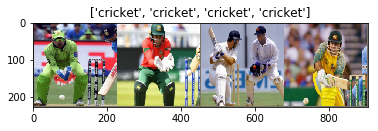

In [43]:
imshow(out, title=[class_names[x] for x in classes])

In [44]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

#### Generic function to display predictions for a few images

In [45]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


#### Finetuning the convnet

In [49]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

In [57]:
# Load a pretrained model and reset final fully connected layer.

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

# Ensuring the model is using GPU
model_ft = model_ft.to(device)

# As we have two classes (0 or 1) we will use cross-entropy as criterion
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


#### Train and evaluate

In [54]:
import time
import os
import copy

In [55]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6853 Acc: 0.5200
val Loss: 0.5815 Acc: 0.6000

Epoch 1/24
----------
train Loss: 0.5293 Acc: 0.7600
val Loss: 0.3442 Acc: 0.8000

Epoch 2/24
----------
train Loss: 0.3499 Acc: 0.8000
val Loss: 0.2971 Acc: 0.8000

Epoch 3/24
----------
train Loss: 0.4096 Acc: 0.7800
val Loss: 0.4417 Acc: 0.6000

Epoch 4/24
----------
train Loss: 0.3328 Acc: 0.8200
val Loss: 0.1498 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.4487 Acc: 0.8000
val Loss: 0.2777 Acc: 0.9000

Epoch 6/24
----------
train Loss: 0.4300 Acc: 0.8600
val Loss: 0.1660 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.0967 Acc: 0.9400
val Loss: 0.2811 Acc: 0.9000

Epoch 8/24
----------
train Loss: 0.1081 Acc: 0.9600
val Loss: 0.2572 Acc: 0.9000

Epoch 9/24
----------
train Loss: 0.2335 Acc: 0.9000
val Loss: 0.1365 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.2477 Acc: 0.9000
val Loss: 0.1440 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.2889 Acc: 0.8800
val Loss: 0.1610 Acc: 1.0000

Ep

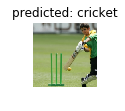

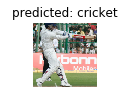

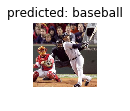

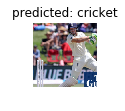

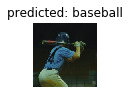

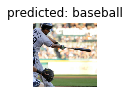

In [56]:
visualize_model(model_ft)

In [62]:
images[0][0]

tensor([[[-1.9295, -1.8782, -1.8439,  ..., -1.9295, -1.9295, -1.9295],
         [-1.9467, -1.8782, -1.8610,  ..., -1.9295, -1.9124, -1.9124],
         [-1.9295, -1.9124, -1.8953,  ..., -1.9467, -1.9295, -1.9124],
         ...,
         [-0.0801, -0.0116,  0.0741,  ...,  0.3652,  0.3138,  0.1254],
         [ 0.0056,  0.0569, -0.1143,  ...,  0.3994,  0.0569, -0.2513],
         [-0.3883, -0.4226, -0.5938,  ...,  0.0741,  0.1597,  0.2796]],

        [[-1.7906, -1.7381, -1.7031,  ..., -1.8431, -1.8431, -1.8431],
         [-1.8081, -1.7381, -1.7206,  ..., -1.8606, -1.8431, -1.8431],
         [-1.7731, -1.7556, -1.7381,  ..., -1.8782, -1.8606, -1.8431],
         ...,
         [-0.4076, -0.3200, -0.2500,  ..., -0.0574, -0.1099, -0.3025],
         [-0.3375, -0.2850, -0.4601,  ...,  0.0301, -0.3375, -0.6352],
         [-0.7752, -0.8102, -0.9853,  ..., -0.3025, -0.2150, -0.0924]],

        [[-1.4384, -1.3861, -1.3513,  ..., -1.5604, -1.5604, -1.5604],
         [-1.4559, -1.3861, -1.3687,  ..., -1

In [30]:
def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

In [39]:
import mimetypes

# Get all image extensions
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))

In [44]:
def get_files(path, extensions=None, recurse=True, folders=None):
    "Get all the files in `path` with optional `extensions`, optionally with `recurse`, only in `folders`, if specified."
    path = path
    folders=list(folders)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path)): # returns (dirpath, dirnames, filenames)
            if len(folders) !=0 and i==0: d[:] = [o for o in d if o in folders]
            else:                         d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        res = _get_files(path, f, extensions)
    return L(res)

In [36]:
def get_image_files(path, recurse=True, folders=None):
    "Get image files in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=image_extensions, recurse=recurse, folders=folders)

In [45]:
items = get_image_files(PATH)
split_idx = RandomSplitter()(items)

TypeError: 'NoneType' object is not iterable

In [29]:
ts = get_image_files(path='/home/ubuntu/datasets/sports_images/')

NameError: name 'get_files' is not defined

In [27]:
ConvLearner.pretrained(arch, data, precompute=True)

In [20]:
resnet = models.resnet50(pretrained=True)

In [16]:
 def from_paths(cls, path, bs=64, tfms=(None,None), trn_name='train', val_name='valid', test_name=None, test_with_labels=False, num_workers=8):
        """ Read in images and their labels given as sub-folder names
        Arguments:
            path: a root path of the data (used for storing trained models, precomputed values, etc)
            bs: batch size
            tfms: transformations (for data augmentations). e.g. output of `tfms_from_model`
            trn_name: a name of the folder that contains training images.
            val_name:  a name of the folder that contains validation images.
            test_name:  a name of the folder that contains test images.
            num_workers: number of workers
        Returns:
            ImageClassifierData
        """
        assert not(tfms[0] is None or tfms[1] is None), "please provide transformations for your train and validation sets"
        trn,val = [folder_source(path, o) for o in (trn_name, val_name)]
        if test_name:
            test = folder_source(path, test_name) if test_with_labels else read_dir(path, test_name)
        else: test = None
        datasets = cls.get_ds(FilesIndexArrayDataset, trn, val, tfms, path=path, test=test)
        return cls(path, datasets, bs, num_workers, classes=trn[2])

In [30]:
from .layer_optimizer import *

ModuleNotFoundError: No module named '__main__.layer_optimizer'; '__main__' is not a package

Most models assume that the input image be square in shape. If not, some libraries might squeeze them to make them square. It's better to have a transformation which crops a square instead of squeezing them, since that distorts the image. This is automatically done in fastai (CropType.RANDOM).

In [43]:
def tfms_from_stats(stats, sz, aug_tfms=None, max_zoom=None, pad=0, crop_type=None,
                    tfm_y=None, sz_y=None, pad_mode='symmetric', norm_y=True, scale=None):
    """ Given the statistics of the training image sets, returns separate training and validation transform functions
    """
    if aug_tfms is None: aug_tfms=[]
    tfm_norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    #tfm_denorm = transforms.Denormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    val_crop = transforms.CropType.CENTER if crop_type in (CropType.RANDOM,CropType.GOOGLENET) else crop_type
    val_tfm = image_gen(tfm_norm, tfm_denorm, sz, pad=pad, crop_type=val_crop,
            tfm_y=tfm_y, sz_y=sz_y, scale=scale)
    trn_tfm = image_gen(tfm_norm, tfm_denorm, sz, pad=pad, crop_type=crop_type,
            tfm_y=tfm_y, sz_y=sz_y, tfms=aug_tfms, max_zoom=max_zoom, pad_mode=pad_mode, scale=scale)
    return trn_tfm, val_tfm

In [36]:
inception_stats = ([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
inception_models = (models.inception_v3, models.Inception3)
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [18]:
def tfms_from_model(f_model, sz, aug_tfms=None, max_zoom=None, pad=0, crop_type=None,
                    tfm_y=None, sz_y=None, pad_mode='symmetric', norm_y=True, scale=None):
    """ Returns separate transformers of images for training and validation.
    Transformers are constructed according to the image statistics given by the model. (See tfms_from_stats)
    Arguments:
        f_model: model, pretrained or not pretrained
    """
    stats = inception_stats if f_model in inception_models else imagenet_stats
    return tfms_from_stats(stats, sz, aug_tfms, max_zoom=max_zoom, pad=pad, crop_type=crop_type,
                           tfm_y=tfm_y, sz_y=sz_y, pad_mode=pad_mode, norm_y=norm_y, scale=scale)

In [44]:
## Following 3 lines of code is used to train the model

## ImageClassifierData.from_paths
# Read in images and their labels given as sub-folder names
# tfms: transformations (for data augmentations). e.g. output of `tfms_from_model`
data = from_paths(PATH, tfms=tfms_from_model(resnet, sz))


NameError: name 'CropType' is not defined

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
# We are working with two types of objects, data - contains training/validation set, learn - contains the model

In [ ]:
## learn.fit()
# The first parameter in learn.fit specifies the learning rate
# The second parameter in learn.fit specifies the number of epochs
learn.fit(0.01, 4)